In [1]:
!pip install ultralytics


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import csv
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# data.yaml dosyasını oluştur
data_yaml = """
path: /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data

train: train/images
val: val/images
test: test/images

nc: 1
names: ['cheerios']
"""

# Dosyayı kaydet
with open('data.yaml', 'w') as file:
    file.write(data_yaml)


In [4]:
model = YOLO("yolov8l.pt")  

model.train(
    data="data.yaml",
    epochs=100,                
    batch=16,                   
    imgsz=640,
    patience=20,               
    optimizer='Adam',          
    lr0=0.0005,                
    weight_decay=0.0001,       
    cos_lr=True,               
    save_period=20,             
    workers=2,
    # Augmentasyonlar
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5,
    fliplr=0.5,
    translate=0.1,
    scale=0.5,
    shear=0.01
)

Ultralytics 8.3.200 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, p

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         69         68      0.954          1      0.993      0.992
Speed: 0.1ms preprocess, 11.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdcef848310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

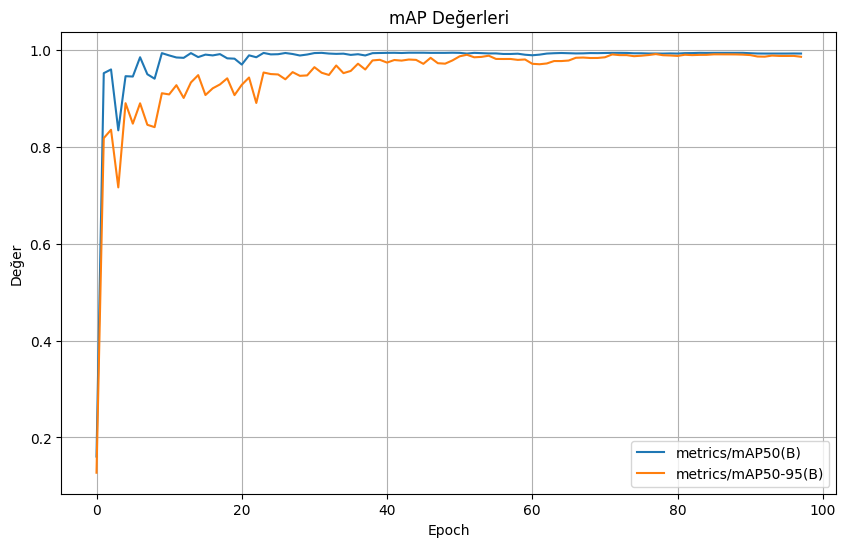

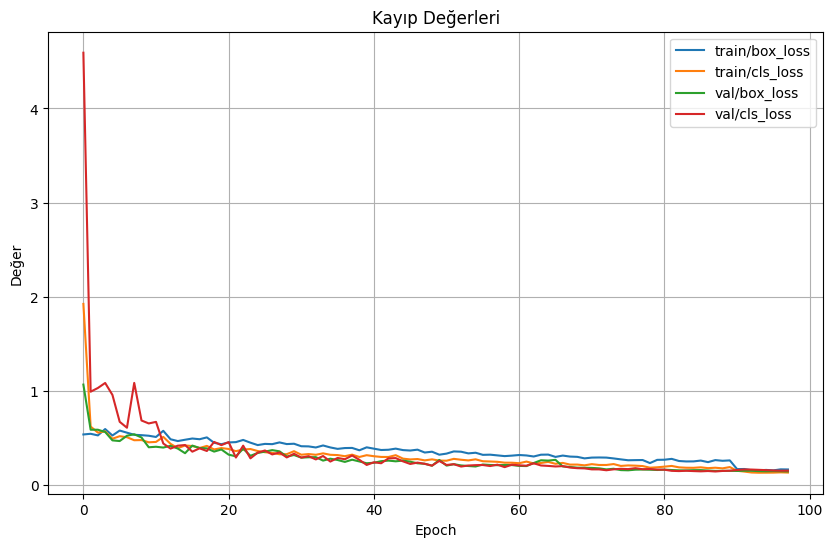

In [5]:
metrics_path = "/kaggle/working/runs/detect/train/results.csv"
metrics = pd.read_csv(metrics_path)

metrics[['metrics/mAP50(B)', 'metrics/mAP50-95(B)']].plot(figsize=(10, 6))
plt.title("mAP Değerleri")
plt.xlabel("Epoch")
plt.ylabel("Değer")
plt.grid()
plt.show()


metrics[['train/box_loss', 'train/cls_loss', 'val/box_loss', 'val/cls_loss']].plot(figsize=(10, 6))
plt.title("Kayıp Değerleri")
plt.xlabel("Epoch")
plt.ylabel("Değer")
plt.grid()
plt.show()


In [6]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

test_images_path = "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images"
output_dir = "/kaggle/working/predictions/labels"

os.makedirs(output_dir, exist_ok=True)

for img_path in Path(test_images_path).glob("*"):
    if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
        continue

    results = model.predict(img_path, conf=0.05)  

    output_txt = Path(output_dir) / f"{img_path.stem}.txt"

    with open(output_txt, "w") as f:
        for result in results:
            img_height, img_width = result.orig_shape
            for box in result.boxes.data:
                x1, y1, x2, y2, confidence, cls_id = box.tolist()

                x_center = ((x1 + x2) / 2) / img_width
                y_center = ((y1 + y2) / 2) / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height

                f.write(f"0 {confidence:.6f} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print(f"[notice] ✅ Tahminler kaydedildi: {output_dir}")


image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0106.jpg: 640x384 1 cheerios, 43.5ms
Speed: 2.0ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/IMG_3114.jpg: 640x640 3 cheerioss, 24.4ms
Speed: 1.5ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0273.jpg: 640x384 2 cheerioss, 19.2ms
Speed: 2.0ms preprocess, 19.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0255.jpg: 640x384 2 cheerioss, 18.6ms
Speed: 1.8ms preprocess, 18.6m

In [7]:
def predictions_to_csv(
    preds_folder: str = "/kaggle/working/predictions/labels", 
    output_csv: str = "/kaggle/working/submissionv.csv", 
    test_images_folder: str = "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images",
    allowed_extensions: tuple = (".jpg", ".png", ".jpeg")
):
    preds_path = Path(preds_folder)
    test_images_path = Path(test_images_folder)

    test_images = {p.stem for p in test_images_path.glob("*") if p.suffix.lower() in allowed_extensions}

    predictions = []
    predicted_images = set()

    for txt_file in preds_path.glob("*.txt"):
        image_id = txt_file.stem
        predicted_images.add(image_id)

        with open(txt_file, "r") as f:
            valid_lines = [line.strip() for line in f if len(line.strip().split()) == 6]

        pred_str = " ".join(valid_lines) if valid_lines else "no boxes"
        predictions.append({"image_id": image_id, "prediction_string": pred_str})

    missing_images = test_images - predicted_images
    for image_id in missing_images:
        predictions.append({"image_id": image_id, "prediction_string": "no boxes"})

    submission_df = pd.DataFrame(predictions)
    submission_df.to_csv(output_csv, index=False, quoting=csv.QUOTE_MINIMAL)

    print(f"[notice] ✅ Submission saved to {output_csv}")


predictions_to_csv()


[notice] ✅ Submission saved to /kaggle/working/submissionv.csv



image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0012 (2).jpg: 640x384 1 cheerios, 18.5ms
Speed: 1.9ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /kaggle/working/runs/detect/predict


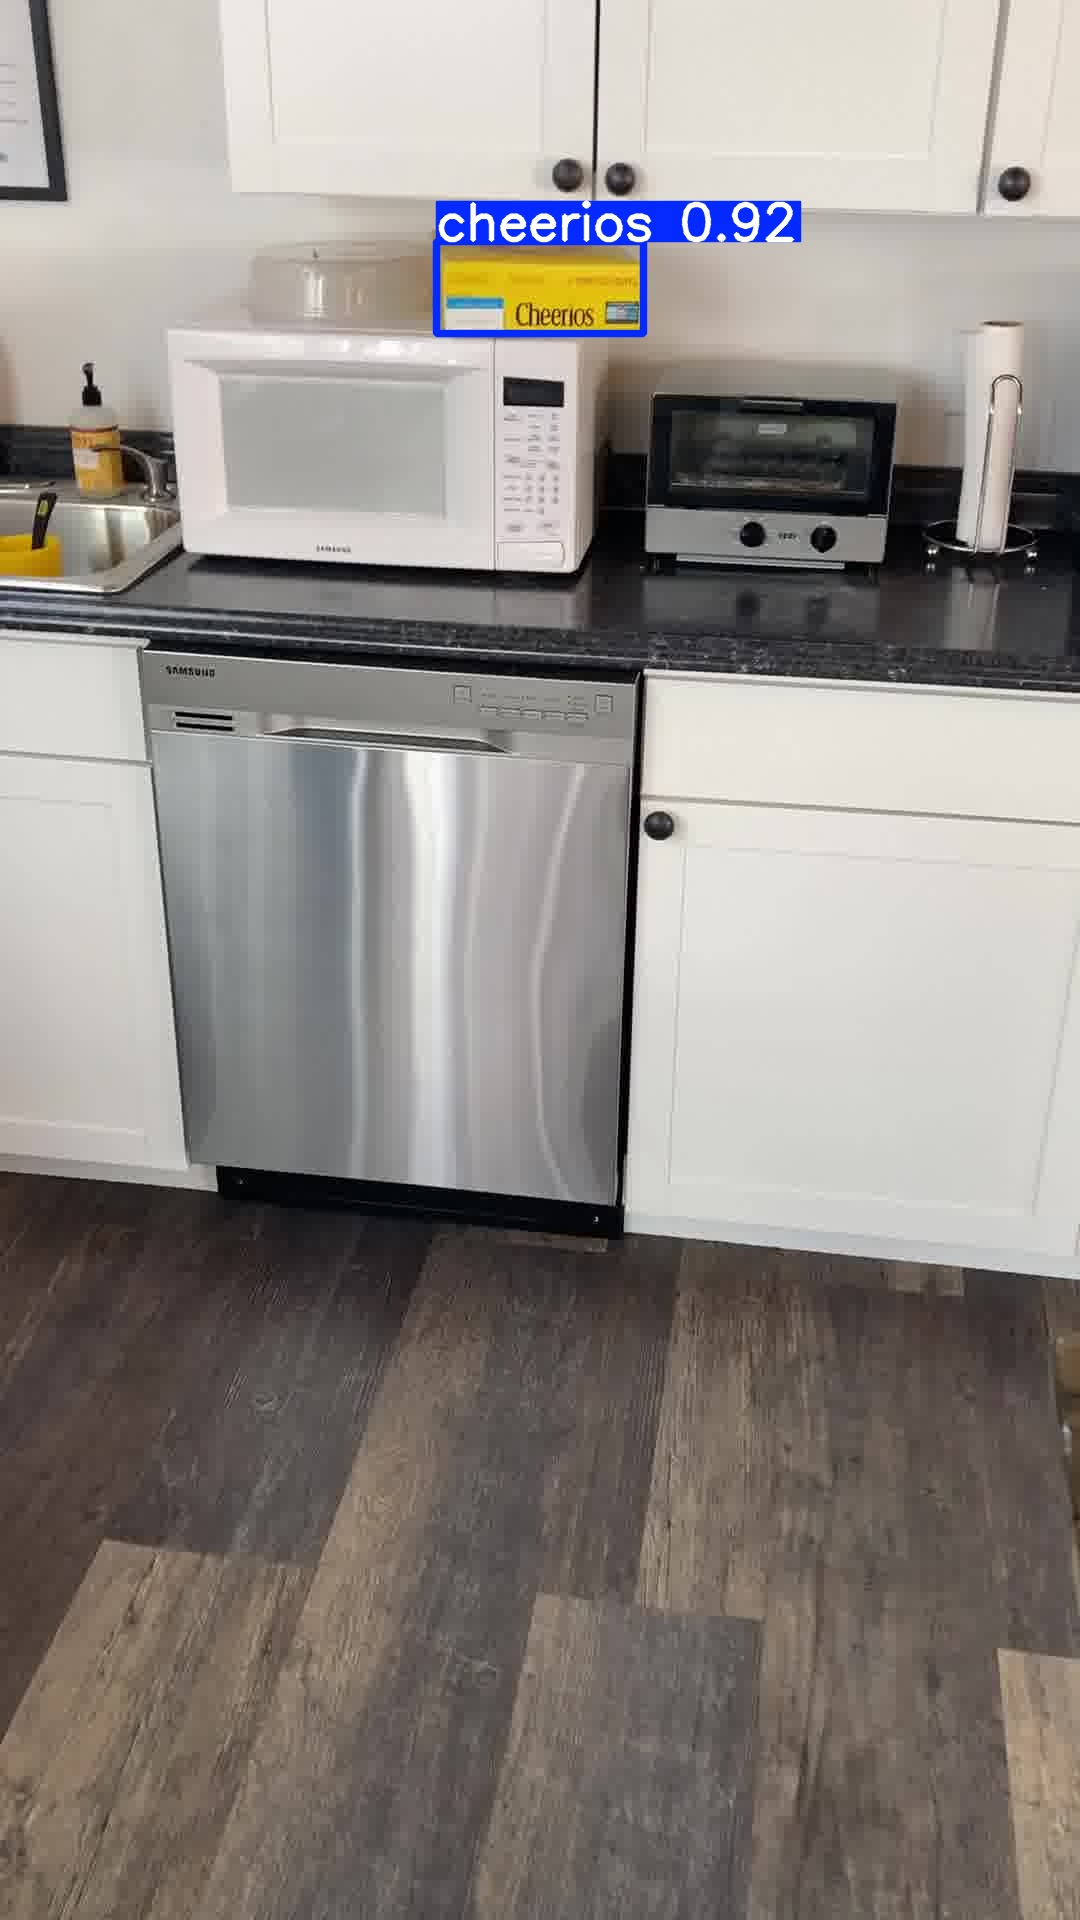

In [8]:
from PIL import Image

results = model.predict(source="/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0012 (2).jpg", conf=0.85, save=True)

Image.open('runs/detect/predict/0012 (2).jpg')